In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import os

import numpy as np
import matplotlib.pyplot as plt

from NormalizingFlows.src.train import train_forward
from NormalizingFlows.src.scores import log_likelihood
from NormalizingFlows.src.utils import update_device, load_best_model, load_checkpoint_model

from NormalizingFlows.src.flows import *
from NormalizingFlows.src.data.variational.linear_regression import LinearRegression
from NormalizingFlows.src.importance_sampling import *


ValueError: r_home is None. Try python -m rpy2.situation

In [5]:
def set_visible_devices(*devices: int) -> None:
    '''Utility to set visible Cuda devices.

    Parameters
    ----------
    devices : List[int]
        Index of cuda devices to make available for use.
    '''
    assert all([d >= 0 for d in devices]), f"Not all devices are CUDA devices!"
    os.environ['CUDA_VISIBLE_DEVICES'] = ",".join([str(i) for i in devices])
    

def set_devices(*devices: int):
    '''Utility to set Cuda device(s).

    Parameters
    ----------
    devices : List[int]
        Index of cuda devices to make available for use.

    Returns
    -------
    torch.device or List[torch.device] of currently available CUDA devices.
    '''
    assert len(devices) > 0, f'Device list is empty, no devices set.'
    if len(devices) == 1:
        if devices[0] >= 0:
            set_visible_devices(devices[0])
            return torch.device(0)
        else:
            return torch.device('cpu')

    else:
        set_visible_devices(*devices)
        return [torch.device(i) for i in range(len(devices))]

In [6]:
device = set_devices(2) #torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device_cpu = torch.device("cpu")

NameError: name 'os' is not defined

In [5]:
dataset = LinearRegression()
dim_input = dataset.dim_input
num_trans = 8
dim_hidden = [300,300,300]

flows = {}
flow_forward = True


epochs = 15
batch_size = 32
batches = 1000
num_exp = 3

In [6]:
#Mean_field

#name = 'Mean field'
#flows[name] = []
#for i in range(num_exp):
#    transformations = create_constant_trans(num_trans, dim_input, flow_forward, a_param=F.softplus)
#    mean_field = create_flows_with_identity(dim_input, transformations, flow_forward) 
#    flows[name] += [mean_field]
#    flows[name][-1].name = f'{name} {i}'

In [7]:
#Affine

name = 'Affine'
flows[name] = []
for i in range(num_exp):
    transformations = create_affine_trans(num_trans, flow_forward)
    aff_ar_alt = create_flows_with_IAR(dim_input, dim_hidden, transformations, 'alternate', flow_forward)
    flows[name] += [aff_ar_alt]
    flows[name][-1].name = f'{name} {i}'

In [8]:
#ContinuousPiecewiseAffineAffine

# name = 'ContinuousPiecewiseAffineAffine'
# flows[name] = []
# for i in range(num_exp):
#     transformations = create_affinecontinuous_trans(num_trans, flow_forward)
#     affconpiec_coup_alt = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
#     flows[name] += [affconpiec_coup_alt]
#     flows[name][-1].name = f'{name} {i}

In [9]:
#Alt. Lin. Aff.Con

#name = 'Alternating Linear_AffineContinuous
#flows[name] = []
#for i in range(num_exp):
#    transformations = create_alt_linear_affinecontinuous_trans(num_trans, dim_input, flow_forward)
#    linaffcont_coup_rand = create_flows_with_alt_identity_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
#    flows[name] += [linaffcont_coup_rand]
#    flows[name][-1].name = f'{name} {i}'


In [10]:
#Alt. Lin. Aff.

#name = 'Alternating Linear_Affine'
#flows[name] = []
#for i in range(num_exp):
#    transformations = create_alt_linear_affine_trans(num_trans, dim_input, flow_forward)
#    linaff_coup_rand = create_flows_with_alt_identity_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
#    flows[name] += [linaff_coup_rand]
#    flows[name][-1].name = f'{name} {i}'

In [12]:
losses = {n: [] for n in flows.keys()}
optimizers = {n: [] for n in flows.keys()}

for flowname in flows.keys():
    for j in range(num_exp):
        # Initialize flow
        flow = flows[flowname][j]
        update_device(device, flow, dataset)

        # Initialize optimizer
        optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-4, weight_decay=1e-2)
        optimizers[flowname].append(optimizer)
        
        # Train and append losses
        losses[flowname].append(
            train_forward(
                flow, 
                flow.base_distr,
                dataset, 
                optimizer, 
                epochs, 
                batch_size,
                batches=batches,
                print_n=200, 
                save_checkpoint=True, 
                burn_in=-1
            )
        )

        # Move flow to CPU
        update_device(device_cpu, flow, dataset)

Finished training. Loss for last epoch Affine 2:         -inf


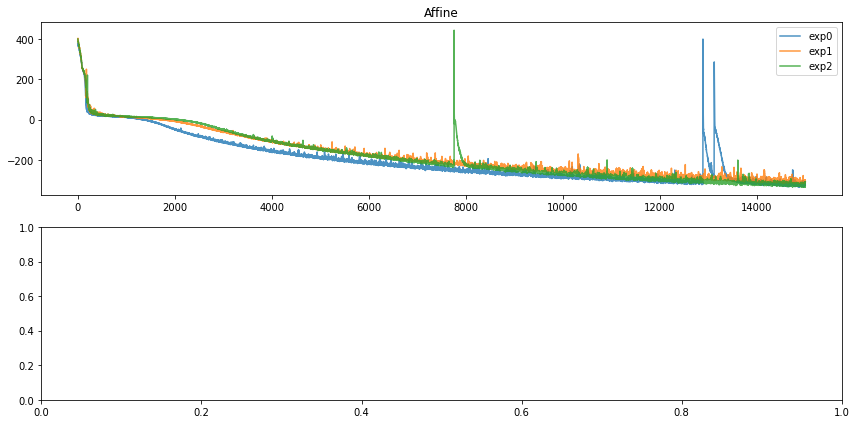

In [14]:
log_scale = False
from_iter = 0 

fig, ax = plt.subplots(2, len(flows), figsize=(12,6))
for j, flowname in enumerate(flows.keys()):
    for i in range(num_exp):
        ax[j].plot(losses[flowname][i], label=f'exp{i}', alpha=0.8)
        ax[j].set_title(f'{flowname}')
        if log_scale:
            ax[j].set_yscale('log')
        ax[j].legend()    
plt.tight_layout()